In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Define an exponential distribution

exponential = tfd.Exponential(rate=0.3, name='exp')

In [5]:
samples = exponential.sample(5000).numpy()

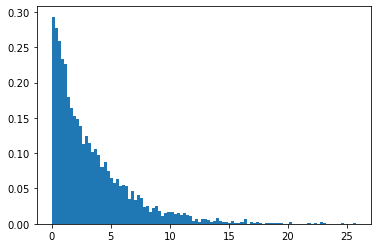

In [6]:
# plot 

plt.hist(samples, bins=100, density=True)
plt.show()

In [7]:
# Define an exponential distribution with a trainable rate parameter

exp_train = tfd.Exponential(rate=tf.Variable(1., name='rate'), name='exp_train')
exp_train.trainable_variables

(<tf.Variable 'rate:0' shape=() dtype=float32, numpy=1.0>,)

In [8]:
# Define the neg log likelihood

def nll(x_train, distribution):
    return -tf.reduce_mean(distribution.log_prob(x_train))

In [9]:
# Define a function that compute the loss and gradients

@tf.function
def get_loss_and_grads(x_train, distribution):
    with tf.GradientTape() as tape:
        tape.watch(distribution.trainable_variables)
        loss = nll(x_train, distribution)
        grads = tape.gradient(loss, distribution.trainable_variables)
    return loss, grads

In [10]:
# Optimze

def exponential_dist_optimization(data, distribution):
    
    # Keep restuls for plotting
    train_loss_returns = []
    train_rate_results = []
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)
    
    num_steps = 10
    
    for i in range(num_steps):
        loss, grads = get_loss_and_grads(data, distribution)
        optimizer.apply_gradients(zip(grads, distribution.trainable_variables))
        
        rate_value = distribution.rate.value()
        train_loss_results.append(loss)
        train_rate_results.append(rate_value)
        print('Step {:03d}: Loss: {:.3f}: Rate: {:.3f}'.format(i, loss, rate_value))
        
    return train_loss_results, train_rate_results

In [11]:
# Get some data and train

train_loss_results, train_rate_results =[], []

sampled_data = exponential.sample(5000)
train_loss_results, train_rate_results = exponential_dist_optimization(data=sampled_data, distribution=exp_train)

Step 000: Loss: 3.280: Rate: 0.886
Step 001: Loss: 3.027: Rate: 0.778
Step 002: Loss: 2.804: Rate: 0.679
Step 003: Loss: 2.614: Rate: 0.588
Step 004: Loss: 2.460: Rate: 0.509
Step 005: Loss: 2.345: Rate: 0.444
Step 006: Loss: 2.268: Rate: 0.392
Step 007: Loss: 2.222: Rate: 0.356
Step 008: Loss: 2.200: Rate: 0.332
Step 009: Loss: 2.192: Rate: 0.319


In [12]:
# Predicted value for the rate parameter

pred_value = exp_train.rate.numpy()
exact_value = exponential.rate.numpy()

print('Exact rate: ', exact_value)
print('Pred rate: ', pred_value)

Exact rate:  0.3
Pred rate:  0.3187789


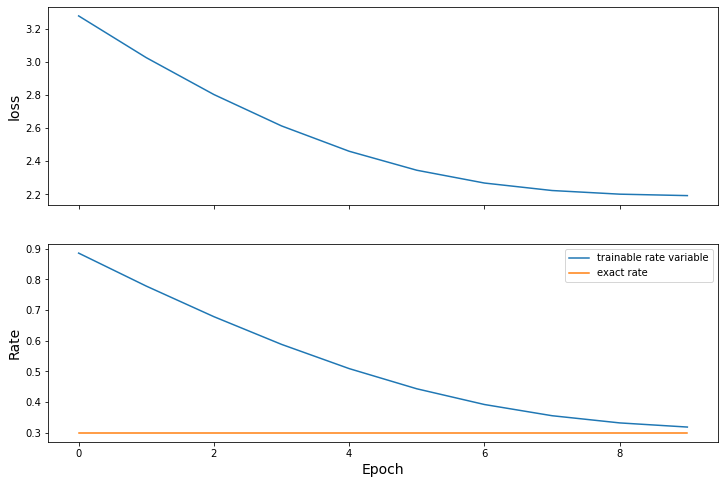

In [13]:
# Plot to see the convergence of the estimated and true parameters

tensor_exact_value = tf.constant(exact_value, shape=[len(train_rate_results)])

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
axes[0].set_ylabel('loss', fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel('Rate', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].plot(train_rate_results, label='trainable rate variable')
axes[1].plot(tensor_exact_value, label='exact rate')
axes[1].legend()

plt.show()

In [14]:
# Making a function to get data which:
#   1) Fetches the 20 newsgroups dataset
#   2) Performs a word count on the articles and binarizes the result
#   3) Returns the data as a numpy matrix with the labels

def get_data(categories):
    
    newsgroups_train_data = fetch_20newsgroups(data_home='20_Newsgroup_Data/',
                                              subset='train', categories=categories)
    newsgroups_test_data = fetch_20newsgroups(data_home='20_Newsgroup_Data/',
                                             subset='test', categories=categories)
    
    n_documents = len(newsgroups_train_data['data'])
    
    # Count words occurences and binarize the result filtering out
    # excessively common words or words that only appear once in our corpus
    count_vectorizer = CountVectorizer(input='content', 
                                       binary=True, 
                                       max_df=0.25, 
                                       min_df=1.01/n_documents)
    
    train_binary_bag_of_words = count_vectorizer.fit_transform(newsgroups_train_data['data'])
    test_binary_bag_of_words = count_vectorizer.transform(newsgroups_test_data['data'])
    
    return (train_binary_bag_of_words.todense(), newsgroups_train_data['target']), (test_binary_bag_of_words.todense(), newsgroups_test_data['target']), 

In [15]:
# Defining a function to conduct Laplace smoothing. This adds a base level of probability for a given feature
# to occur in every class

def laplace_smoothing(labels, binary_data, n_classes):
    # Compute the parameter estimates (adjusted fraction of documents in class that contain word)
    n_words = binary_data.shape[1]
    alpha = 1 # parameter for the Laplace smoothing
    theta = np.zeros([n_classes, n_words]) # stores parameter values - prob. word given class
    for c_k in range(n_classes): # 0, 1, ..., 19
        class_mask = (labels == c_k)
        N = class_mask.sum() # number of articles in class
        theta[c_k,:] = (binary_data[class_mask, :].sum(axis=0) + alpha)/(N + alpha*2)
        
    return theta

In [16]:
# Getting a subset of the 20 newsgroups dataset

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

(train_data, train_labels), (test_data, test_labels) = get_data(categories)
smoothed_counts = laplace_smoothing(labels=train_labels, binary_data=train_data, n_classes=len(categories))

To make our NB classifier we need to build three functions:

* Compute the class priors
* Build our class conditional statements
* Put it all together and classify our data

In [17]:
# Function which computes the prior probability of every class based on the frequency of occurence in
# the dataset

def class_priors(n_classes, labels):
    counts = np.zeros(n_classes)
    for c_k in range(n_classes):
        counts[c_k] = np.sum(np.where(labels==c_k, 1, 0))
    priors = counts/np.sum(counts)
    print('The class priors are {}'.format(priors))
    return priors

In [18]:
# Run the function

priors = class_priors(n_classes=len(categories), labels=train_labels)

The class priors are [0.2359882  0.28711898 0.29154376 0.18534907]


In [19]:
# Now we will do a function that given the feature occurence counts returns a Bernoulli distribution of
# batch_shape = number of classes and event_shape = number of features

def make_distribution(probs):
    batch_of_bernoullis = tfd.Bernoulli(probs=probs)
    dist = tfd.Independent(batch_of_bernoullis,
                          reinterpreted_batch_ndims=1)
    return dist

tf_dist = make_distribution(smoothed_counts)
tf_dist

<tfp.distributions.Independent 'IndependentBernoulli' batch_shape=[4] event_shape=[17495] dtype=int32>

In [20]:
# The final function predict_sample which given the distribution, a test sample, and the class priors:
#    1) Computes the class conditional probabilities given the sample
#    2) Forms the joint likelihood
#    3) Normalizes the joint likelihood and returns the log prob

def predict_sample(dist, sample, priors):
    cond_probs = dist.log_prob(sample)
    joint_likelihood = tf.add(np.log(priors), cond_probs)
    norm_factor = tf.math.reduce_logsumexp(joint_likelihood, axis=-1, keepdims=True)
    log_prob = joint_likelihood - norm_factor
    
    return log_prob

In [21]:
# Now we learn the distribution using gradient tape

def make_distribution_withGT(data, labels, nb_classes):
    
    class_data = []
    train_vars = []
    distributions = []
    
    for c in range(nb_classes):
        train_vars.append(tf.Variable(initial_value=np.random.uniform(low=0.01, high=0.1, size=data.shape[-1])))
        distributions.append(tfd.Bernoulli(probs=train_vars[c]))
        class_mask = (labels == c)
        class_data.append(data[class_mask, :])
        
    for c_num in range(0, nb_classes):
        optimizer = tf.keras.optimizers.Adam()
        print('\n%--------------%')
        print('Class', c_num)
        print('%----------------%')
        
        for i in range(0,100):
            loss, grads = get_loss_and_grads(class_data[c_num], distributions[c_num])
            if(i%10==0):
                print('iter: {} loss: {}'.format(i, loss))
            optimizer.apply_gradients(zip(grads, distributions[c_num].trainable_variables))
            
            # we need to constraint our parameters to be between 0 and 1
            # because we are working with Bernoulli distributions. We will do this
            # by clipping the value of the parameters (not a good idea)
            eta = 1e-3
            clipped_probs = tf.clip_by_value(distributions[c_num].trainable_variables,
                                            clip_value_min=eta, clip_value_max=1)
            train_vars[c_num] = tf.squeeze(clipped_probs)
            
    dist = tfd.Bernoulli(probs=train_vars)
    dist = tfd.Independent(dist, reinterpreted_batch_ndims=1)
    
    print(dist)
    
    return dist

In [22]:
# Make the same naive bayes as we did last tutorial

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

(train_data, train_labels), (test_data, test_labels) = get_data(categories)

smoothed_counts = laplace_smoothing(labels=train_labels, binary_data=train_data, n_classes=len(categories))

priors = class_priors(n_classes=len(categories), labels=train_labels)
tf_dist = make_distribution(smoothed_counts)

The class priors are [0.2359882  0.28711898 0.29154376 0.18534907]


In [23]:
# Now train the distribution with gradient tape

GT_dist = make_distribution_withGT(data=train_data, labels=train_labels, nb_classes=4)


%--------------%
Class 0
%----------------%
iter: 0 loss: 0.07809071966166382
iter: 10 loss: 0.06873457411396262
iter: 20 loss: 0.060028010590804856
iter: 30 loss: 0.051979121860591254
iter: 40 loss: 0.04452837302566198
iter: 50 loss: 0.03765022591003495
iter: 60 loss: 0.03129295104804009
iter: 70 loss: 0.0254066769300967
iter: 80 loss: 0.019948211041690016
iter: 90 loss: 0.01487129469841063

%--------------%
Class 1
%----------------%
iter: 0 loss: 0.07130350963943019
iter: 10 loss: 0.061981335143728174
iter: 20 loss: 0.053199404915103436
iter: 30 loss: 0.04503470838006533
iter: 40 loss: 0.03746778351212339
iter: 50 loss: 0.030470857877262773
iter: 60 loss: 0.024008042488276343
iter: 70 loss: 0.018045079929050252
iter: 80 loss: 0.012548223025563682
iter: 90 loss: 0.007460337627152815

%--------------%
Class 2
%----------------%
iter: 0 loss: 0.07850353333636977
iter: 10 loss: 0.06941113547084435
iter: 20 loss: 0.06103920812266291
iter: 30 loss: 0.053411111534691726
iter: 40 loss: 0.0

In [24]:
# Compare the two results

for dist in [GT_dist, tf_dist]:
    probabilities=[]
    for sample, label in zip(test_data, test_labels):
        probabilities.append(predict_sample(dist, sample, priors))
    
    probabilities = np.asarray(probabilities)
    predicted_classes = np.argmax(probabilities, axis=-1)
    print('f1 ', f1_score(test_labels, predicted_classes, average='macro'))

f1  0.8306343247510536
f1  0.7848499112849504


We don't get exactly the same values because we applied different smoothing operators. In the first case, we applied Laplace smoothing, while in the second we define a minimum value in the clipping operation.